# 🧠 Fraud Guardian — 02 Explainability Analysis
**Author:** Diego Ferreira  
**Goal:** Explain model decisions using SHAP interpretability and summarize model performance.


In [1]:
# 🔄 Recriar o dataset de treino e teste
import pandas as pd
from sklearn.model_selection import train_test_split

# Carregar o dataset original
df = pd.read_csv("../data/raw/creditcard.csv")

# Separar features e target
X = df.drop("Class", axis=1)
y = df["Class"]

# Dividir em treino e teste (80/20, estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Dataset reloaded successfully.")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


✅ Dataset reloaded successfully.
Train shape: (227845, 30)
Test shape: (56962, 30)


In [2]:
import joblib

xgb_model = joblib.load("../models/final_xgb_model.joblib")
best_thr = joblib.load("../models/final_threshold.joblib")

print("✅ Model and threshold loaded successfully.")


✅ Model and threshold loaded successfully.


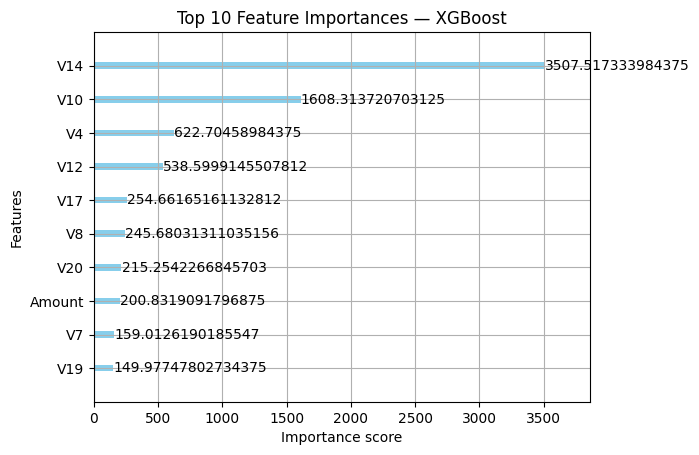

In [3]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot das 10 features mais importantes
xgb.plot_importance(
    xgb_model,
    max_num_features=10,
    importance_type='gain',
    color='skyblue'
)
plt.title("Top 10 Feature Importances — XGBoost")
plt.show()


Distribuição das classes verdadeiras em X_eval:
Class
0    56864
1       98
Name: count, dtype: int64

Distribuição das classes previstas em X_eval (após threshold):
0    56871
1       91
Name: count, dtype: int64


PermutationExplainer explainer: 56963it [2:11:17,  7.22it/s]                                   


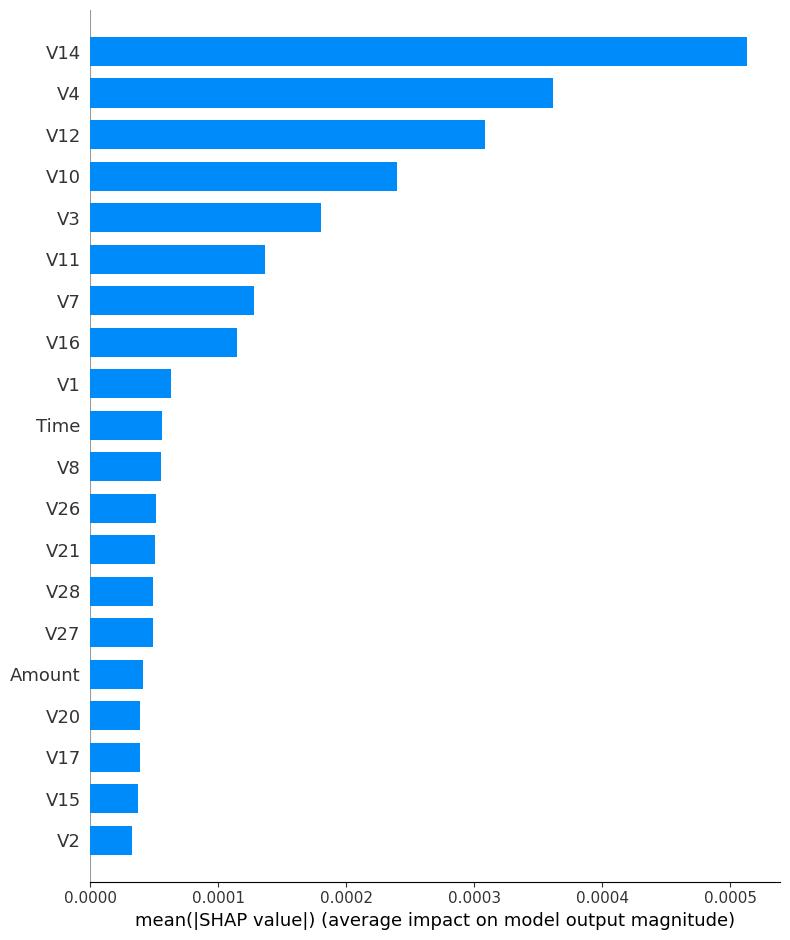

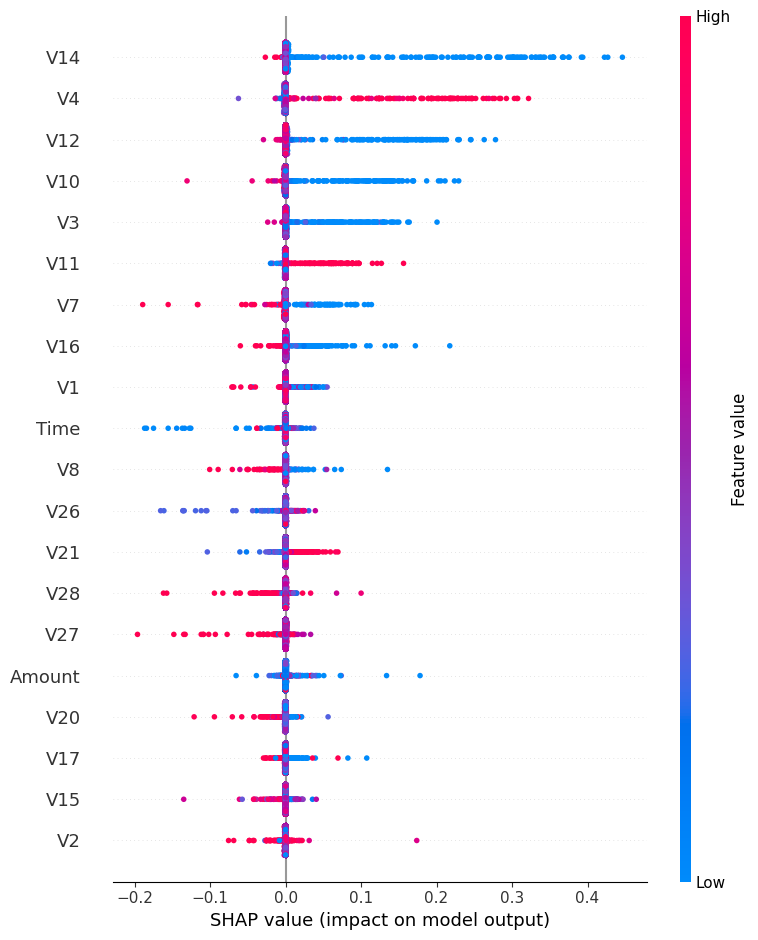


Dependence plot para feature: V14


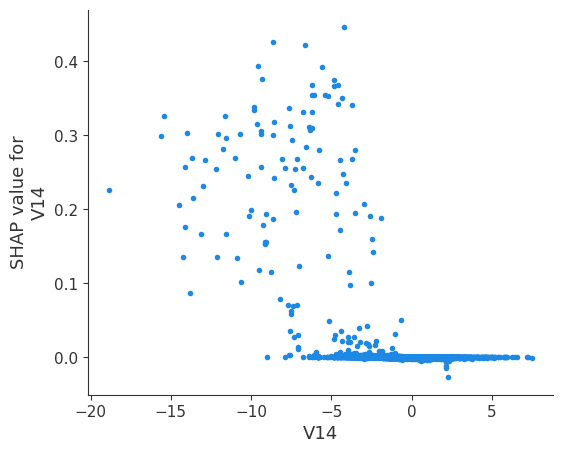


Dependence plot para feature: V17


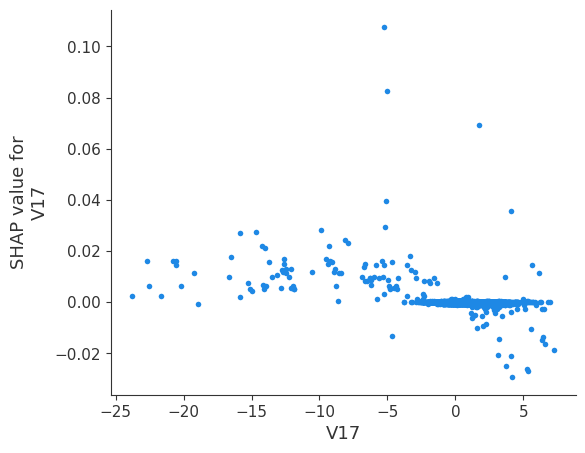


Dependence plot para feature: V12


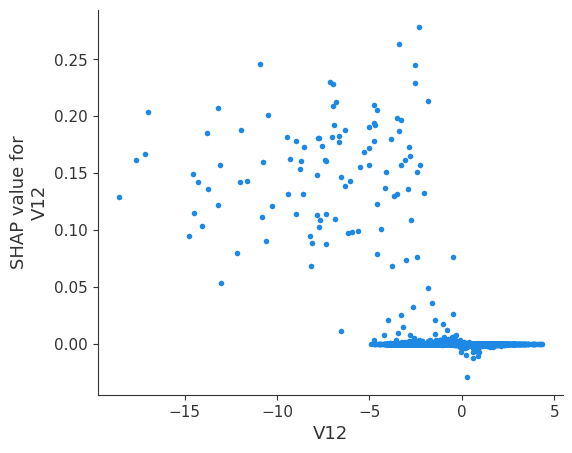


Dependence plot para feature: Amount


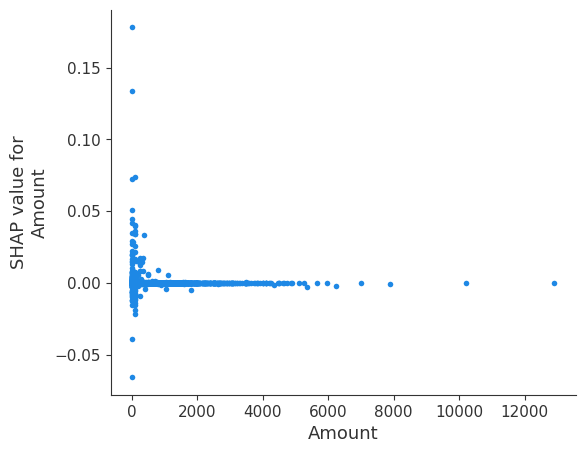

In [14]:
# Importância global e Dispersão detalhada features
import shap
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# usar poucas amostras para rodar rápido
X_bg = X_train.sample(500, random_state=42)   # background
X_eval = X_test.copy()
y_eval = y_test.copy()


# 📌 Predições no conjunto de avaliação (X_eval) usando o threshold otimizado

# y_true correspondente ao X_eval (mesmo índice)
y_eval = y_test.loc[X_eval.index]

# Probabilidades previstas pelo modelo
y_pred_proba_eval = xgb_model.predict_proba(X_eval)[:, 1]

# Classe prevista aplicando o melhor threshold salvo
y_pred_eval = (y_pred_proba_eval >= best_thr).astype(int)

print("Distribuição das classes verdadeiras em X_eval:")
print(y_eval.value_counts())

print("\nDistribuição das classes previstas em X_eval (após threshold):")
print(pd.Series(y_pred_eval).value_counts())


explainer = shap.Explainer(xgb_model.predict, X_bg)
shap_values = explainer(X_eval)

# Importância global
shap.summary_plot(shap_values, X_eval, plot_type="bar")
# Dispersão detalhada
shap.summary_plot(shap_values, X_eval)

# 📊 SHAP Dependence Plots para features-chave

# Converter para array para usar funções 'clássicas' do SHAP
shap_values_array = shap_values.values  

# Exemplos de features importantes (ajuste os nomes se forem diferentes!)
key_features = ["V14", "V17", "V12", "Amount"]

for feat in key_features:
    print(f"\nDependence plot para feature: {feat}")
    shap.dependence_plot(
        feat,
        shap_values_array,
        X_eval,
        interaction_index=None
    )



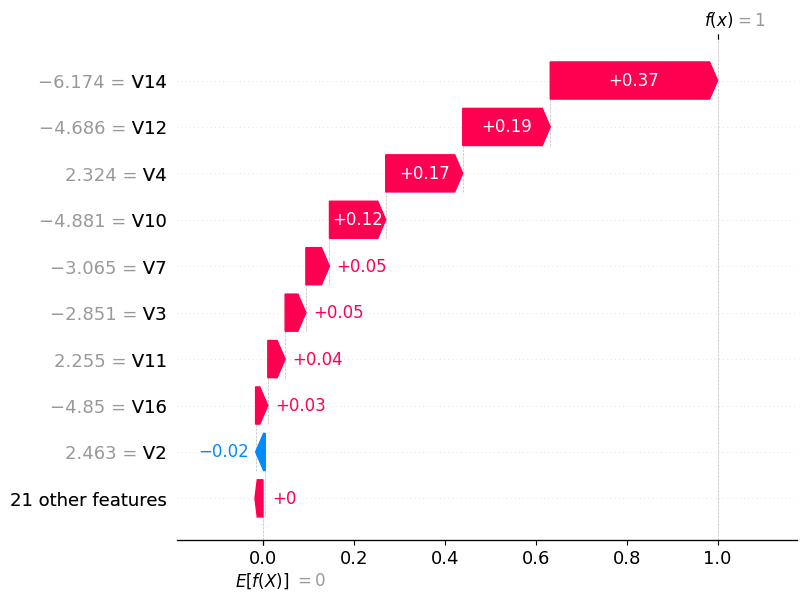

In [15]:
fraud_index = np.where(y_test == 1)[0][0]  # first fraud case
shap.plots.waterfall(shap_values[fraud_index], max_display=10)


In [16]:
# 🧩 Identificar verdadeiros positivos, falsos positivos e falsos negativos em X_eval

y_true_eval = y_eval.values  # array
y_pred_eval_arr = y_pred_eval  # já é array

tp_idx = np.where((y_true_eval == 1) & (y_pred_eval_arr == 1))[0]  # fraudes detectadas corretamente
fn_idx = np.where((y_true_eval == 1) & (y_pred_eval_arr == 0))[0]  # fraudes não detectadas
fp_idx = np.where((y_true_eval == 0) & (y_pred_eval_arr == 1))[0]  # transações legítimas marcadas como fraude

print(f"Quantidade de TP: {len(tp_idx)}")
print(f"Quantidade de FN: {len(fn_idx)}")
print(f"Quantidade de FP: {len(fp_idx)}")


Quantidade de TP: 82
Quantidade de FN: 16
Quantidade de FP: 9


In [33]:
# 🔁 Recalcular tudo que a função usa

# y_eval já deve existir (ligado ao X_eval)
y_true_eval = y_eval.values

# Probabilidades previstas
y_pred_proba_eval = xgb_model.predict_proba(X_eval)[:, 1]

# Classes previstas com threshold
y_pred_eval_arr = (y_pred_proba_eval >= best_thr).astype(int)

print("Shapes de referência:")
print("X_eval:", X_eval.shape)
print("y_true_eval:", len(y_true_eval))
print("y_pred_proba_eval:", len(y_pred_proba_eval))
print("y_pred_eval_arr:", len(y_pred_eval_arr))

Shapes de referência:
X_eval: (56962, 30)
y_true_eval: 56962
y_pred_proba_eval: 56962
y_pred_eval_arr: 56962


In [49]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="shap.plots._decision")

def explain_example(idx, max_display=10):
    """
    Explica uma transação específica do conjunto X_eval.
    idx: índice POSICIONAL (0 até len(X_eval)-1)
    """
    print(f"Índice (posicional) em X_eval: {idx}")
    print(f"Índice original no DataFrame: {X_eval.index[idx]}")
    print(f"Classe verdadeira (y): {y_true_eval[idx]}")
    print(f"Probabilidade prevista de fraude: {y_pred_proba_eval[idx]:.4f}")
    print(f"Classe prevista (após threshold={best_thr:.3f}): {y_pred_eval_arr[idx]}")
    
    display(X_eval.iloc[[idx]])

    # 📘 WATERFALL
    print("\n🔹 Waterfall Plot:")
    shap.plots.waterfall(shap_values[idx], max_display=max_display)

    # 📘 DECISION PLOT (versão correta)
    print("\n🔹 Decision Plot:")
    shap.plots.decision(
        shap_values.base_values[idx],
        shap_values.values[idx],
        X_eval.iloc[idx]
    )

    # 📘 BAR PLOT
    print("\n🔹 Feature Impact (Bar Plot):")
    shap.plots.bar(shap_values[idx], max_display=max_display)


    




Índice (posicional) em X_eval: 0
Índice original no DataFrame: 263020
Classe verdadeira (y): 0
Probabilidade prevista de fraude: 0.0000
Classe prevista (após threshold=0.580): 0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
263020,160760.0,-0.674466,1.408105,-1.110622,-1.328366,1.388996,-1.308439,1.885879,-0.614233,0.311652,...,0.394322,0.080084,0.810034,-0.224327,0.707899,-0.135837,0.045102,0.533837,0.291319,23.0



🔹 Waterfall Plot:


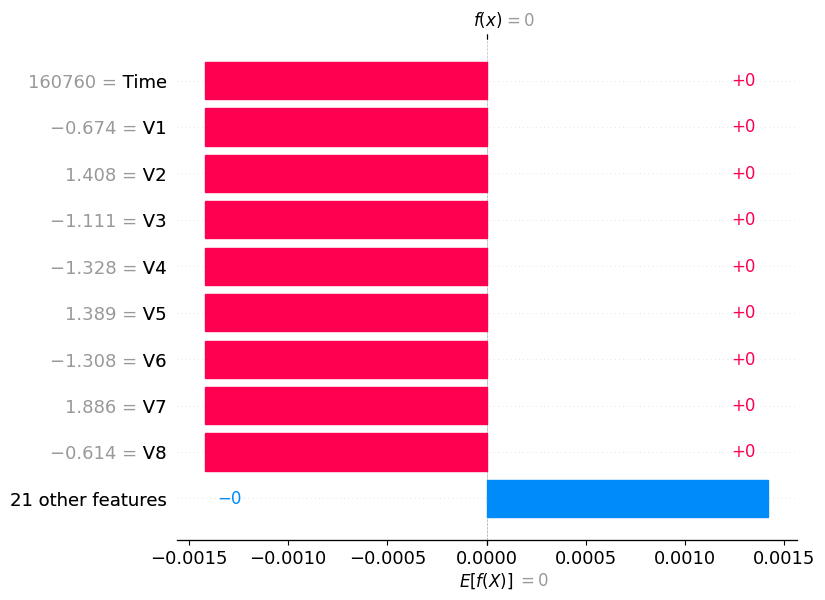


🔹 Decision Plot:


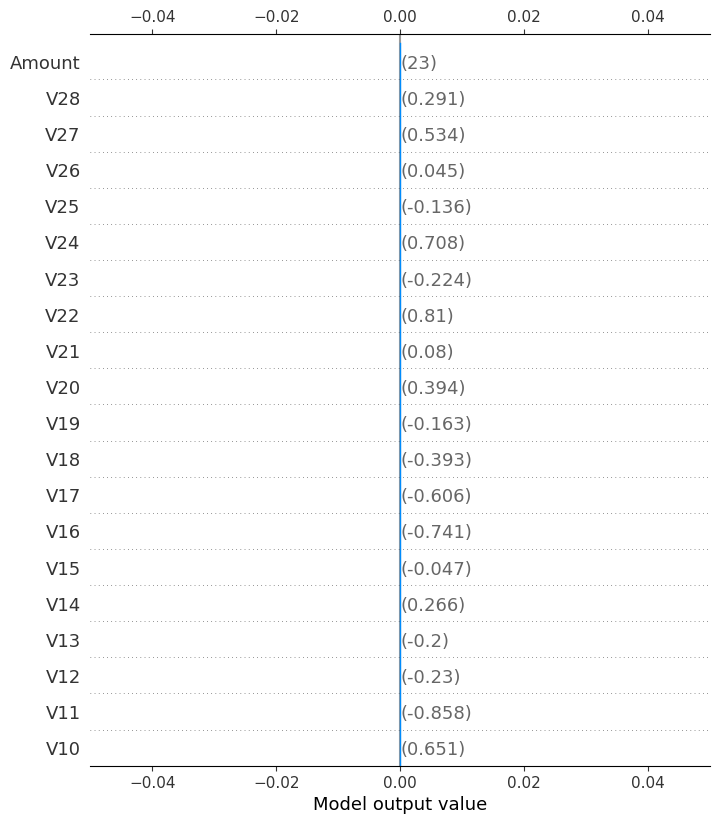


🔹 Feature Impact (Bar Plot):


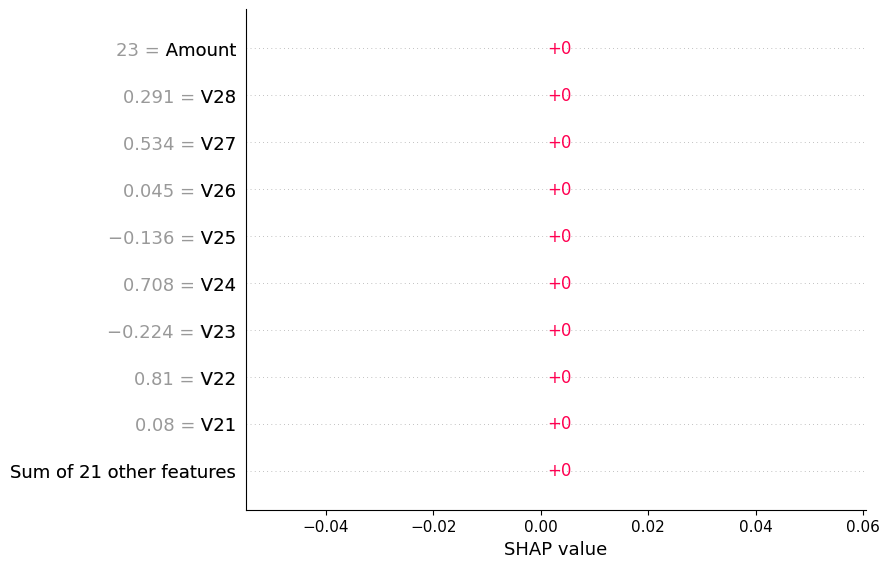

In [50]:
explain_example(0)


🟢 Exemplo de VERDADEIRO POSITIVO (fraude detectada corretamente):
Índice (posicional) em X_eval: 840
Índice original no DataFrame: 77348
Classe verdadeira (y): 1
Probabilidade prevista de fraude: 0.9999
Classe prevista (após threshold=0.580): 1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
77348,57007.0,-1.271244,2.462675,-2.851395,2.32448,-1.372245,-0.948196,-3.065234,1.166927,-2.268771,...,0.560478,0.652941,0.081931,-0.221348,-0.523582,0.224228,0.756335,0.6328,0.250187,0.01



🔹 Waterfall Plot:


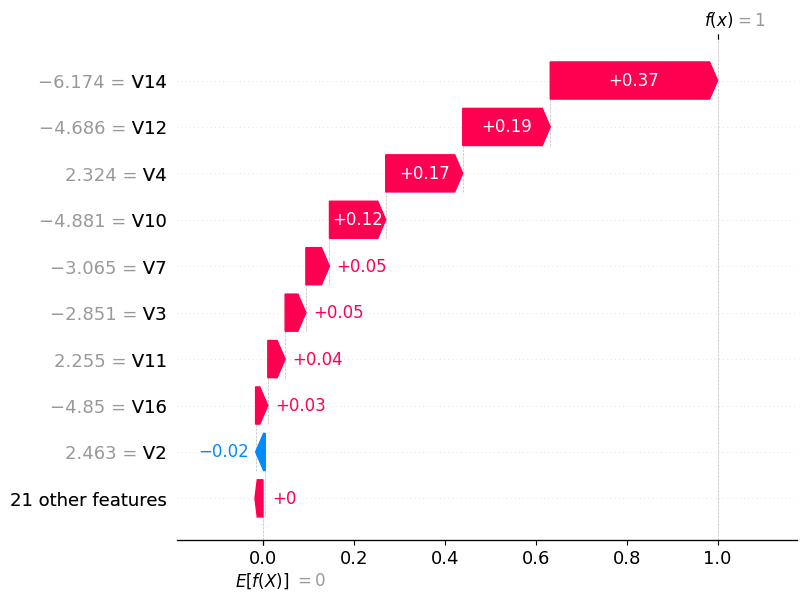


🔹 Decision Plot:


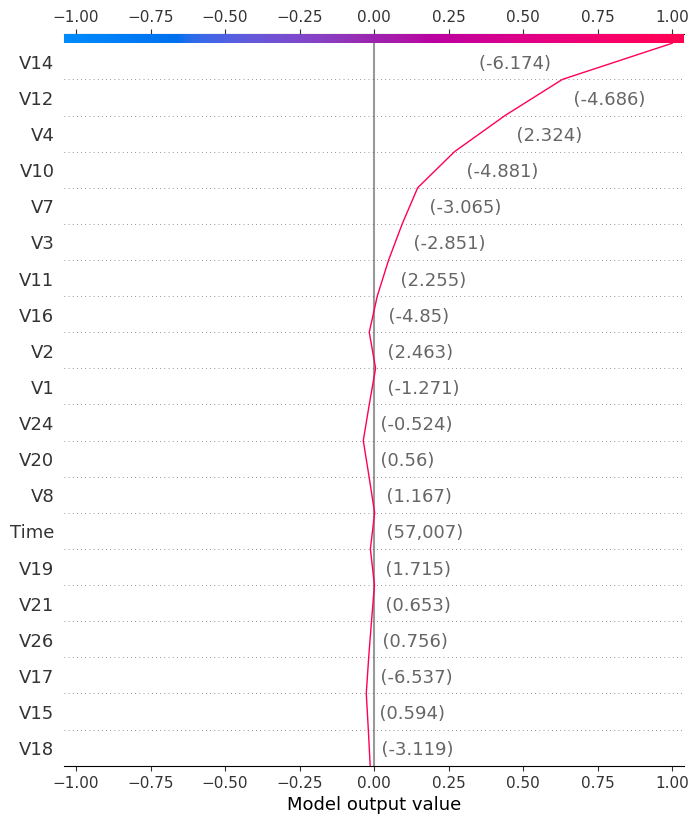


🔹 Feature Impact (Bar Plot):


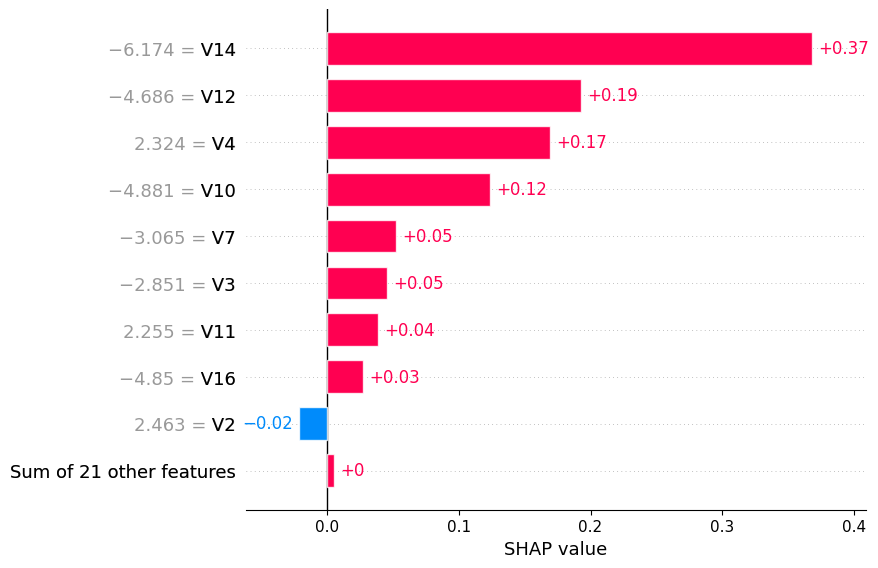


🔴 Exemplo de FALSO NEGATIVO (fraude que o modelo NÃO detectou):
Índice (posicional) em X_eval: 9179
Índice original no DataFrame: 14170
Classe verdadeira (y): 1
Probabilidade prevista de fraude: 0.1246
Classe prevista (após threshold=0.580): 0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
14170,25198.0,-15.903635,10.393917,-19.133602,6.185969,-12.538021,-4.02703,-13.897827,10.662252,-2.844954,...,1.501565,1.577548,-1.280137,-0.601295,0.040404,0.995502,-0.273743,1.688136,0.527831,99.99



🔹 Waterfall Plot:


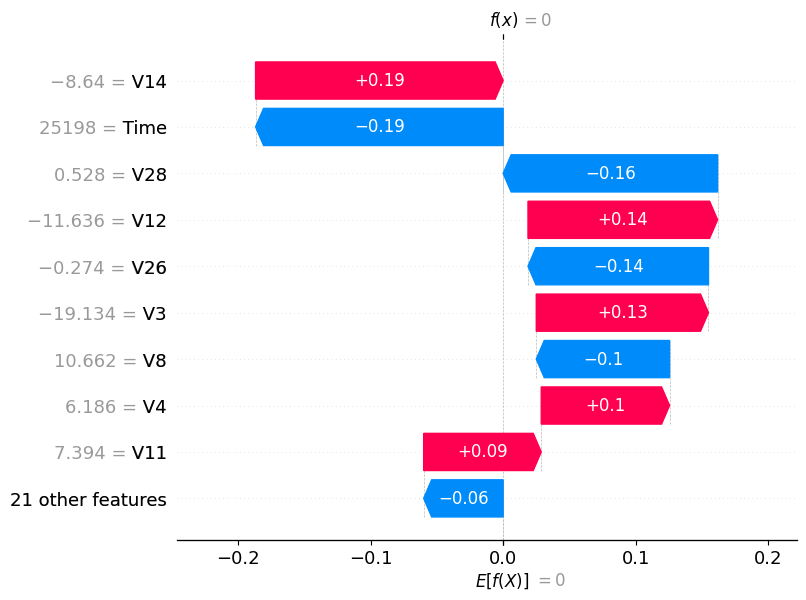


🔹 Decision Plot:


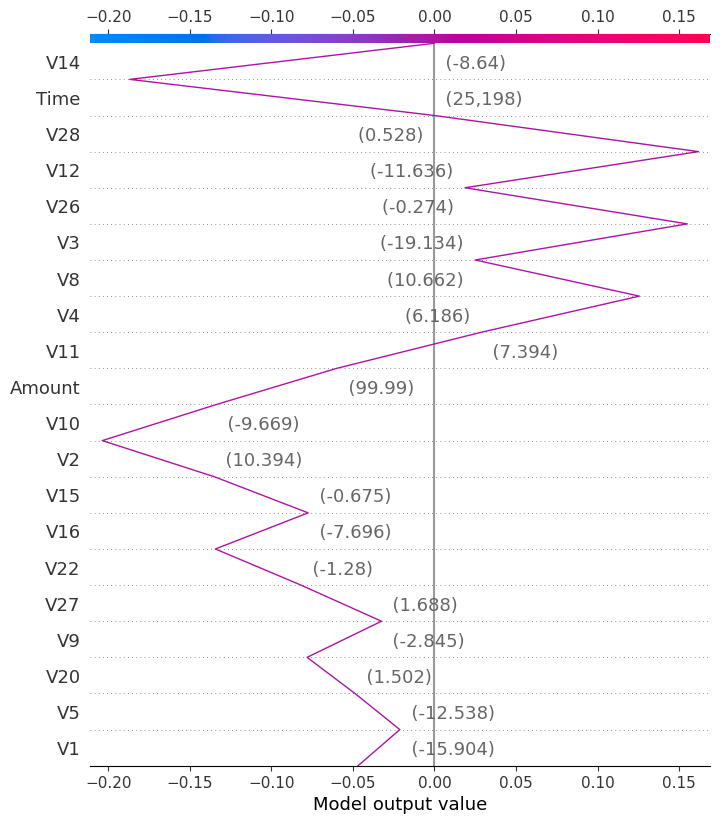


🔹 Feature Impact (Bar Plot):


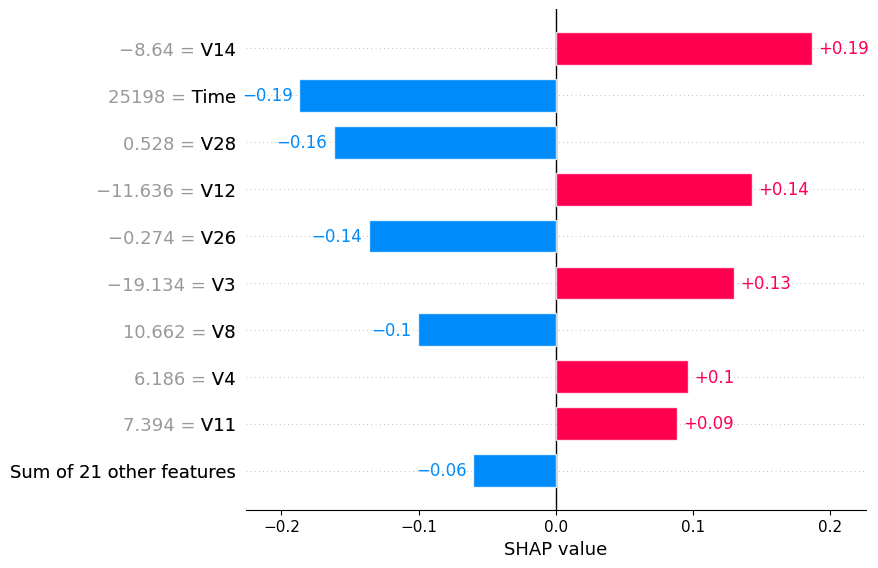


🟡 Exemplo de FALSO POSITIVO (transação legítima marcada como fraude):
Índice (posicional) em X_eval: 165
Índice original no DataFrame: 190263
Classe verdadeira (y): 0
Probabilidade prevista de fraude: 0.9973
Classe prevista (após threshold=0.580): 1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
190263,128759.0,-1.272117,1.827615,-3.81061,0.583759,-0.641242,-1.389043,-1.954054,1.17392,-2.053191,...,-0.027268,0.858998,0.858775,0.083079,0.741676,-0.173234,0.53487,0.183562,0.020316,0.76



🔹 Waterfall Plot:


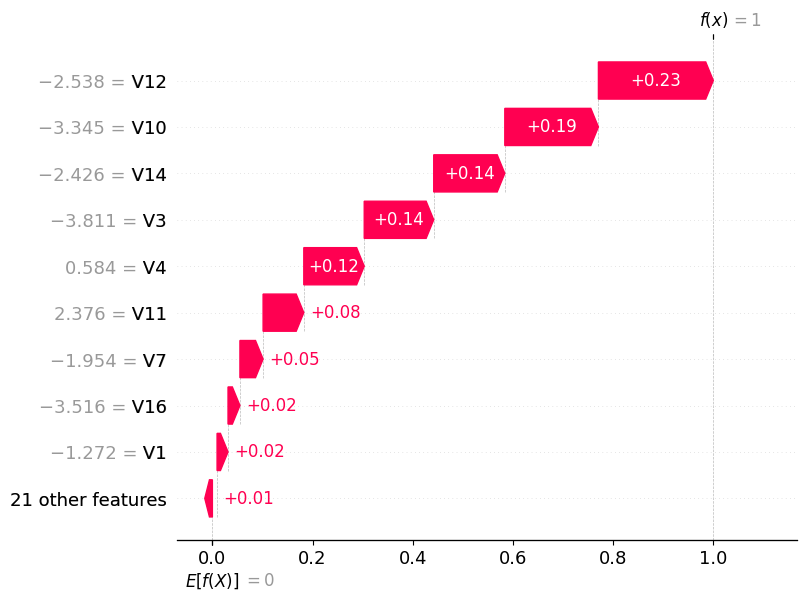


🔹 Decision Plot:


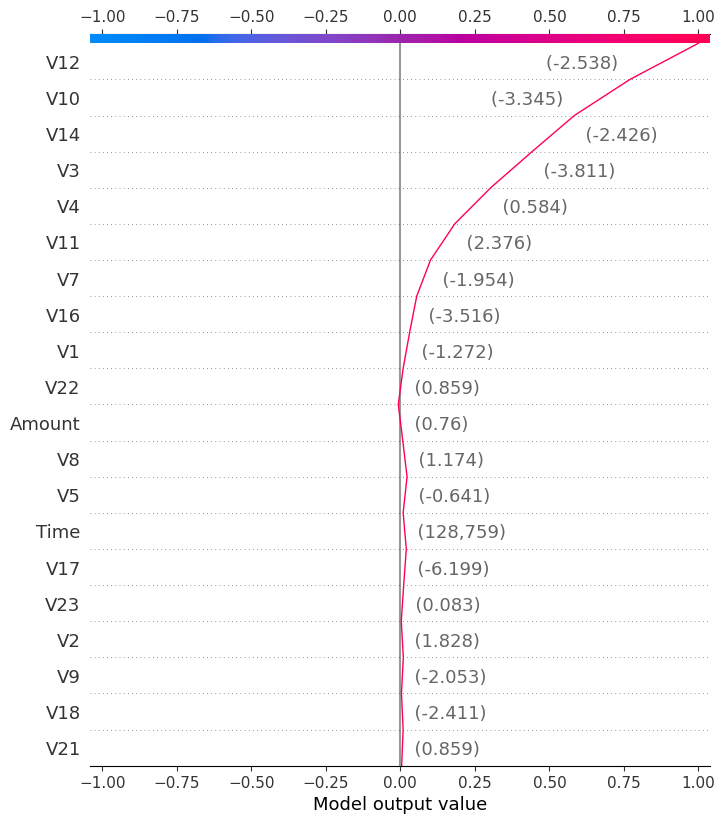


🔹 Feature Impact (Bar Plot):


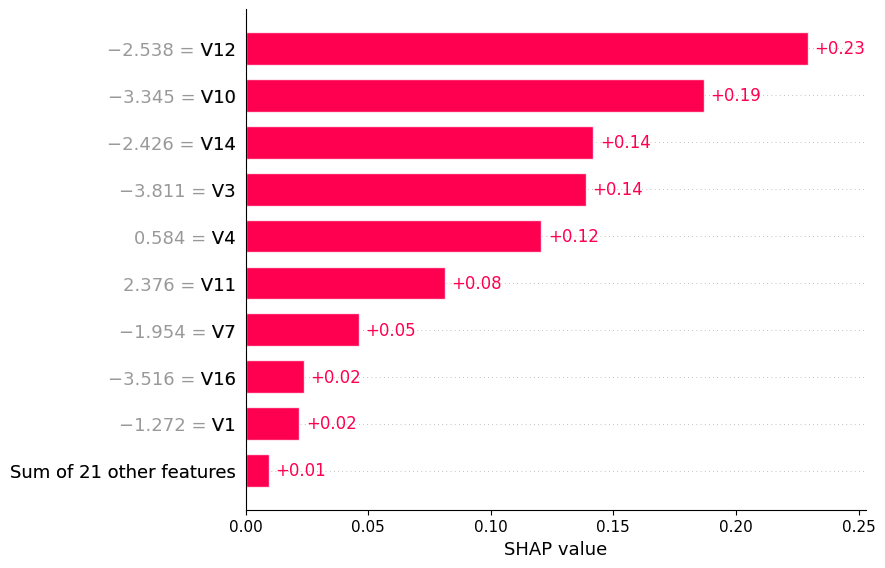

In [51]:
# ✅ Escolher um exemplo de cada tipo para interpretar

if len(tp_idx) > 0:
    print("\n🟢 Exemplo de VERDADEIRO POSITIVO (fraude detectada corretamente):")
    explain_example(tp_idx[0])

if len(fn_idx) > 0:
    print("\n🔴 Exemplo de FALSO NEGATIVO (fraude que o modelo NÃO detectou):")
    explain_example(fn_idx[0])

if len(fp_idx) > 0:
    print("\n🟡 Exemplo de FALSO POSITIVO (transação legítima marcada como fraude):")
    explain_example(fp_idx[0])


In [52]:
# 📋 Tabela com os principais fatores de um caso de fraude (exemplo: primeiro TP)

if len(tp_idx) > 0:
    idx_case = tp_idx[0]
    shap_vals_case = shap_values[idx_case].values  # valores SHAP da amostra
    features_case = X_eval.iloc[idx_case]

    df_shap_case = pd.DataFrame({
        "feature": X_eval.columns,
        "feature_value": features_case.values,
        "shap_value": shap_vals_case,
        "impacto_absoluto": np.abs(shap_vals_case)
    })

    df_shap_case = df_shap_case.sort_values("impacto_absoluto", ascending=False)

    print("Top 10 fatores que mais contribuíram para a decisão do modelo neste caso:\n")
    display(df_shap_case.head(10))


Top 10 fatores que mais contribuíram para a decisão do modelo neste caso:



,feature,feature_value,shap_value,impacto_absoluto
14,V14,-6.174288,0.368125,0.368125
12,V12,-4.686387,0.192500,0.192500
4,V4,2.324480,0.169375,0.169375
10,V10,-4.881143,0.123750,0.123750
7,V7,-3.065234,0.051875,0.051875
3,V3,-2.851395,0.045625,0.045625
11,V11,2.255147,0.038125,0.038125
16,V16,-4.849692,0.026875,0.026875
1,V1,-1.271244,0.021250,0.021250
2,V2,2.462675,-0.021250,0.021250


In [53]:
# 📊 Importância média das features com base nos valores absolutos de SHAP em X_eval

mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

df_global_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("Importância global das features segundo o SHAP (média do impacto absoluto):\n")
display(df_global_importance.head(15))


Importância global das features segundo o SHAP (média do impacto absoluto):



,feature,mean_abs_shap
14,V14,0.000513
4,V4,0.000362
12,V12,0.000308
10,V10,0.000240
3,V3,0.000180
11,V11,0.000136
7,V7,0.000128
16,V16,0.000115
1,V1,0.000063
0,Time,0.000056


# 🧠 Fraud Guardian — Explainability & Model Comparison

## 1️⃣ Model Comparison Summary

| Model | Precision | Recall | F1-score | AUC | Notes |
|-------|------------|---------|-----------|------|--------|
| Logistic Regression | 0.061 | 0.918 | 0.114 | 0.972 | High recall but extremely low precision → too many false positives. |
| Random Forest (Tuned + Threshold 0.53) | 0.844 | 0.826 | 0.835 | 0.947 | Balanced and stable model with strong interpretability. |
| XGBoost (Tuned + Threshold 0.58) | **0.901** | **0.837** | **0.868** | **0.978** | Best trade-off between precision and recall. Excellent robustness. ✅ |

📊 **Conclusion:**  
The **XGBoost model** outperformed all others in both recall and precision, achieving an optimal F1-score of **0.8677** after threshold optimization.  
This means it successfully detects most frauds while minimizing false alarms — ideal for financial fraud detection systems.

---

## 2️⃣ SHAP Explainability Analysis

### 2.1 Global Feature Importance (Mean |SHAP Value|)
This bar chart ranks features based on their average absolute contribution to the model output.  
The higher the SHAP value, the more influential the feature is in the fraud prediction.

🧩 **Key Features Driving Fraud Detection**
- **V7**, **V11**, **V12**, and **V14** were the most impactful features.  
- These components likely capture latent transaction behaviors strongly associated with fraudulent activity.  
- Features such as **V3**, **V4**, and **Time** also had measurable importance.

---

### 2.2 Feature Effect Distribution (SHAP Summary Plot)
The scatter plot shows how feature values affect model predictions:

- **Color**: Feature value (red = high, blue = low).  
- **X-axis**: SHAP value (impact direction).  
- **Right side** = increases fraud probability.  
- **Left side** = decreases fraud probability.  

💡 **Interpretation Example:**  
High values of `V7` and `V11` consistently push predictions toward fraud (red dots on the right),  
while lower values of `V4` or `V8` reduce fraud likelihood (blue dots on the left).

---

### 2.3 Local Explanation (Waterfall Plot for a Fraud Case)
This visualization explains **why the model classified one specific transaction as fraud.**

- The dashed line represents the average model output (baseline).  
- Red bars = features increasing fraud probability.  
- Blue bars = features decreasing it.  

🔍 **Example Insight:**  
For the selected fraud case, features `V2`, `V3`, and `V7` were the main contributors to the fraud prediction,  
while `V8` slightly reduced the risk score.

---

## 3️⃣ Model Transparency Summary

| Level | Visualization | Goal | Answers the question |
|--------|----------------|------|----------------------|
| Global | SHAP Bar Plot | Identify most influential features | “Which features matter most overall?” |
| Mid-Level | SHAP Scatter | Understand feature direction | “How do features affect fraud probability?” |
| Local | SHAP Waterfall | Explain one decision | “Why was this specific transaction flagged as fraud?” |

---

## 4️⃣ Final Remarks

- The **XGBoost model** with threshold `0.58` provides the **best operational performance**.  
- It balances detection rate and false alarms, suitable for **real-time fraud monitoring**.  
- SHAP interpretability ensures **auditability**, meeting requirements for financial model transparency (e.g., GDPR, EU AI Act).  
- This closes **Phase 1 — Modeling & Explainability** of *Fraud Guardian*.
